# Description of the model

**General definition of the system dynamics:**

The dynamical system is as follows: it describes the translation of a point-mass in the plane. The $x$ and $y$ coordinates follow the same dynamics without interaction so only the displacement along the $x$ axis is described here (*Please note:* the $y$ coordinate is governed by the same dynamics). The state vector ($\mathbf{x}$) contains the hand position ($p$), the velocity ($\dot{p}$), the commanded force $F_{Com}$, the external force ($F_{Ext}$), the cursor position ($p_c$), and the cursor offset ($p_{\textrm{off}}$): $\mathbf{x} = [p,\dot{p},F_{Com},F_{Ext},p_c,p_{\textrm{off}}]$.

The dynamical system is:
\begin{eqnarray}
\dot{\mathbf{x}} = A_0\mathbf{x}+B_0\mathbf{u} + \textrm{noise},
\end{eqnarray}
with the matrices defined as:

\begin{eqnarray}
A_0=\left[\begin{array}{cccccc}
0 & 1 & 0 & 0 & 0 & 0 \\
0 & -G/m & 1/m & 1/m & 0 & 0 \\
0 & 0 & -1/\tau & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0
\end{array}\right], \qquad
B_0=\left[\begin{array}{c}
0 \\
0\\
1/\tau\\
0\\
0\\
0
\end{array}\right].\\
\end{eqnarray}

The mass parameter is set to unity ($m=1kg$) and the viscous constant to $G=0.1Nsm^{-1}$ as standard value. The parameter $\tau$ captures muscle dymamics as a low pass filter with time constant set to $66$ms compatible with the physiology (Brown and Loeb, 2000). This continuous system is transformed into a discrete time system with first order, Euler integration: $A = I_{6\times 6} + \delta t A_0$ and $B = \delta t B_0$.

**Implementation of perturbations (visual cursor shift & mechanical load):**

Following the dicretization the cursor position is defined as follows:
\begin{eqnarray}
A[4,:] = [1\quad \delta t\quad 0\quad 0\quad 0\quad 1],\\
\end{eqnarray}
such that the cursor coordinate is $p_{\textrm{c,t+1}} = p_{\textrm{t+1}} + p_{\textrm{off,t}}$. This definition allows dissociating the mass (hand) and the cursor, such that we can define a cost-function that penalises the distance between the cursor and the target, which may differ from the distance between the mass and the target. The observability matrix ($H$) does not allow observing $p_{\textrm{off}}$, which is used to induce the **cursor shift**. Thus the cursor and mass coordinates are estimated without observing the offset directly. The mechanical load is simulated by setting the external force $F_{Ext} =$ load value [N].

Finally, the system is also augmented to include the target state (which is why the full state has dimension 24).

**Implementation of experimental manipulations (visual uncertainty & movement time):**

The observed differences in feedback corrections depending on the level of **visual uncertainty** (cursor cloud) are simulated by changing the value of the sensory noise. The measurement/feedback signal is:
\begin{eqnarray}
\mathbf{y}_t = H\mathbf{x}_t + \omega_t.
\end{eqnarray}
Changing the variance of the cloud can be modelled by changing the value of $\Sigma_{\omega} := E(\omega \omega^T)$ that affects the feedback about the cursor position ($p_c$). This was done by multipling or dividing by 10 in the corresponding line as follows:

`# in function runSimulations`<br>
`SigmaOmega[4,4] = SigmaOmega[4,4]*0.1  # sigma low`<br>
`SigmaOmega[4,4] = SigmaOmega[4,4]*1    # sigma medium`<br>
`SigmaOmega[4,4] = SigmaOmega[4,4]*10   # sigma high`<br>

The **movement time** constraint was manipulated by changing the simulated movement time. To simulate *slow* movements we chose $0.7s$ (range in experiment was $0.6 - 0.8s $) and to simulate *fast* movements we chose $0.4s$ (range in experiment was $0.3 - 0.5s $).

**How to run the simulations:**

The simulations are run by executing subsection **Run simulations & Make figures**. Default parameters for the simulations can also be changed in this subsection. To run the model including signal-dependent (multiplicative) noise set parameter `multnoise=True` (default is `False`).

**Explanation of different functions:**

The functions `setupSystem` and `augmentMatrices` define the discrete time & augmented state space matrices and cost matrices as well as the motor & sensory noise covarance matrices.

The function `basicLQG` takes the model, cost, and noise covariance matrices to calculate the optimal control gains and Kalman gains when *only additive motor & sensory noise* is present (algorithm based on Todorov (2005) Eq. 2).

The functions `extLQG`, `computeExtControl`, and `computeExtKalman` take the model, cost, and noise covariance matrices to iteratively calculate the optimal control gains and Kalman gains when *signal-dependent motor & sensory noise* is present (algorithm based on Todorov (2005) Eq. 4 & Eq. 7).

The function `runSimulations` simulates the movements given the perturbations and experimental manipulations described above.

# Model Code

In [ ]:
# @title Import python packages: numpy, matplotlib.pyplot, seaborn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # plot style


In [ ]:
# @title LQG Functions for additive & signal-dependent noise models

def setupSystem(G,m,tau,delta,nState,nCtrl,nAug,nStep,nStab,r,wposh,wposc,wvel,
                tarycoor,motorNoise,sensoryNoise,motorSdn0,motorSdn1,sensorySdn,
                estVar):
  """
  Set up of matrices for system dynamics, cost function, noise terms, and
  state vectors.

  Parameters:
  - G (float): viscous constant [Ns/m].
  - m (float): point-mass [kg].
  - tau (float): muscle time constant [s].
  - delta (float): dicretization time step [s].
  - nState (int): size of the unaugmented state vector
  - nCtrl (int): size of the control vector.
  - nAug (int): size of the augmented state vector.
  - nStep (int): total number of discrete time-steps for simulation.
  - nStab (int): number of discrete time-steps for stabilization phase.
  - r (float): control cost.
  - wposh (int): weight on hand position.
  - wposc (int): weight on cursor position.
  - wvel (int): weight on velocity.
  - tarycoor (float): target y-coordinate [m].
  - motorNoise (float):
  - sensoryNoise (float):
  - motorSdn0 (float):
  - motorSdn1 (float):
  - sensorySdn (float):
  - estVar (float):

  Returns:
  np.ndarrays of floats: matrices for system dynamics, cost function, noise
  terms, and state vectors.
  """
  #-----------------------------------------------------------------------------
  # Note state vector indices x-dim:
  # 0 = pos hand x
  # 1 = vel hand x
  # 2 = internal force x
  # 3 = external force x
  # 4 = pos cursor x
  # 5 = offset hand-cursor x
  # same for y-dim: indices 6-11
  # target augmented state: indices 12-23
  #-----------------------------------------------------------------------------

  # define system dynamics (A & B matrices)
  A0 = np.zeros(shape=(nState,nState))
  B0 = np.zeros(shape=(nState,nCtrl))
  # A
  # x-dimension:
  A0[0,0:6] = [0,1,0,0,0,0]  # pos
  A0[1,0:6] = [0,-G/m,1/m,1/m,0,0]  # vel
  A0[2,0:6] = [0,0,-1/tau,0,0,0]  # force (internal)
  # y-dimension:
  A0[6,6:12] = [0,1,0,0,0,0]
  A0[7,6:12] = [0,-G/m,1/m,1/m,0,0]
  A0[8,6:12] = [0,0,-1/tau,0,0,0]
  # B
  B0[2,:]=[1/tau,0]  # int. force x-dimension
  B0[8,:]=[0,1/tau]  # int. force y-dimension

  # define state cost (non-zero only during stabilization time)
  w = np.zeros(shape=(nState,nStep+1))
  for jj in range(0,nStab+1):
    w[:,nStep-jj] = [wposh,wvel,0,0,wposc,0,wposh,wvel,0,0,wposc,0]

  # augment system with target state
  A,B,R,Q = augmentMatrices(A0,B0,delta,r,w)

  # add cursor position dynamics
  A[4,0:6] = [1,delta,0,0,0,1]  # x-dimension
  A[10,6:12] = [1,delta,0,0,0,1]  # y-dimension

  # define observation matrix
  H = np.identity(nAug)
  H[5,5] = 0  # x cursor offset is not observable
  H[11,11] = 0  # y cursor offset is not observable

  # define additive motor noise
  SigmaXi = motorNoise*B@np.transpose(B)

  # define additive sensory noise
  SigmaOmega = sensoryNoise*np.identity(nAug)

  # initialize state vector
  xstate = np.zeros(shape=(nStep+1,nAug))
  xest = np.zeros(shape=(nStep+1,nAug))
  xstate[0,18] = tarycoor # Target for hand along the y-axis
  xstate[0,22] = tarycoor # Target for cursor along the y-axis
  xest[0,18] = tarycoor
  xest[0,22] = tarycoor

  # define control dependent motor noise
  C = np.zeros(shape=(nAug,nCtrl,nCtrl))
  C[[2,8],0:2,0] = np.diag([motorSdn0, motorSdn0]) #*1
  shifted = np.roll(np.diag([motorSdn1, -motorSdn1]),shift=(-1, 0),axis=(0, 1)) #*1
  C[[2,8],0:2,1] = shifted

  # define state dependent sensory noise
  D = sensorySdn*np.identity(nAug)

  # initialize error and state estimation covariance
  SigmaE = estVar*np.identity(nAug)  # ce in Matlab code
  SigmaXhat = estVar*np.identity(nAug)  # cxhat in Matlab code

  # initial state vector
  xInit = xstate[0,:]

  return A,B,R,Q,H,SigmaXi,SigmaOmega,xstate,xest,C,D,SigmaE,SigmaXhat,xInit

def augmentMatrices(A0,B0,delta,r,w):
  """
  For non-delayed OFC model: Augments system matrices with target states
  & discretizes system matrices and sets up cost matrices.

  Parameters:
  Takes as input the matrices of continuous time differential equation,
  timestep and weights for the definition of the cost matrices.
  - A0 (np.ndarray of floats): Continuous time passive dynamics matrix.
  - B0 (np.ndarray of floats): Continuous time active dynamics matrix.
  - delta (float): Dicretization time step (scalar).
  - r (float): Control cost (scalar).
  - w (np.ndarray of floats): Position cost matrix.

  Returns:
  np.ndarrays of floats: discrete time system matrices (A, B) and cost matrices
  (Q, R).
  """
  # Dimension parameters
  nStep = w.shape[1]-1  # number of simulation time steps
  na0 = A0.shape[1]     # length of original state vector
  nb = B0.shape[1]      # second dimension of control vector

  # Augment matrices A and B with target state & discretize
  A = np.zeros(shape=(2*na0,2*na0))
  A[0:na0,0:na0]=A0
  A = np.identity(2*na0)+delta*A
  B = np.zeros(shape=(2*na0,nb))
  B[0:na0,0:nb] = B0
  B = delta*B

  # Setup cost matrices
  # Control cost
  R = np.zeros(shape=(nStep,nb,nb))
  for i in range(nStep):
    R[i,:,:] = r*np.identity(nb)

  # State cost
  Q = np.zeros(shape=(nStep+1,2*na0,2*na0))
  vec = np.zeros(shape=(2*na0,1))
  id = np.identity(na0)
  for i in range(nStep+1):
    for j in range(na0):
        id_temp = id[:,j]
        vec[0:na0,0] = np.transpose(id_temp)
        vec[na0:2*na0,0] = -np.transpose(id_temp)
        Q[i,:,:] = Q[i,:,:]+ w[j,i]*vec@np.transpose(vec)

  return A, B, R, Q

################################################################################
# Function for additive noise model

def basicLQG(A,B,Q,R,H,SigmaXi,SigmaOmega):
  """
  Computes optimal control and Kalman gains for OFC model including
  only additive motor and sensory noise (see Todorov, 2005 Eq. 2).

  Parameters: all are np.ndarrays of floats
  Takes as input the matrices corresponding to the state space representation,
  the cost matrices, and the noise covariance matrices.
  - A: Augmented & discrete time passive dynamics matrix.
  - B: Augmented & discrete time active dynamics matrix.
  - Q: Augmented position cost matrix.
  - R: Control cost matrix.
  - H: Observation matrix.
  - SigmaXi: Additive motor noise covariance matrix.
  - SigmaOmega: Additive sensory noise covariance matrix.

  Returns:
  np.ndarrays of floats: time series of optimal control and Kalman gains for
  simulations of LQG control with additive noise.
  """
  # Dimension parameters
  nStep = R.shape[0]  # number of simulation time steps
  na = A.shape[1]     # length of augmented state vector (incl. target)
  nb = B.shape[1]     # second dimension of control vector
  ny = H.shape[1]     # length of feedback vector (y)

  # Backward recurrence to compute optimal control gains
  S = np.zeros(shape=(nStep+1,na,na))
  S[nStep,:,:] = Q[nStep,:,:]
  L = np.zeros(shape=(nStep,nb,na))
  sadd = 0
  for i in reversed(range(nStep)):
    L[i,:,:] = np.linalg.inv(R[i,:,:]+np.transpose(B)@S[i+1,:,:]@B)@np.transpose(B)@S[i+1,:,:]@A
    S[i,:,:] = Q[i,:,:]+np.transpose(A)@S[i+1,:,:]@(A-B@L[i,:,:])
    sadd = sadd + np.trace(S[i+1,:,:]@SigmaXi)

  # Forward recurrence to compute optimal Kalman gains
  Sigma = SigmaXi
  K = np.zeros(shape=(nStep,na,ny))
  for i in range(nStep):
    K[i,:,:] = A@Sigma@np.transpose(H)@np.linalg.inv(H@Sigma@np.transpose(H)+SigmaOmega)
    Sigma = SigmaXi + (A-K[i,:,:]@H)@Sigma@np.transpose(A)

  return L, K

################################################################################
# Functions for signal-dependent noise model

def extLQG(A,B,Q,R,H,C,D,SigmaXi,SigmaOmega,SigmaE,SigmaXhat,xInit):
  """
  Iteratively computes optimal control and Kalman gains for OFC model including
  signal-dependent motor and sensory noise based on algorithm in Todorov (2005).
  Note: this version does not include internal noise (SigmaEta=0).

  Parameters: all are np.ndarrays of floats
  Takes as input the matrices corresponding to the state space representation,
  the cost matrices, the noise, state, & error covariance matrices,
  and the intial augmented state vector.
  - A: Augmented & discrete time passive dynamics matrix.
  - B: Augmented & discrete time active dynamics matrix.
  - Q: Augmented position cost matrix.
  - R: Control cost matrix.
  - H: Observation matrix.
  - C: Signal-dependent motor noise matrix.
  - D: Signal-dependent sensory noise matrix.
  - SigmaXi: Additive motor noise covariance matrix.
  - SigmaOmega: Additive sensory noise covariance matrix.
  - SigmaE: Covariance matrix of estimation error.
  - SigmaXhat: Covariance matrix of estimated state.
  - xInit: Initial augmented state vector.

  Returns:
  np.ndarrays of floats: time series of optimal control and Kalman gains (L,K)
  for simulations of LQG control with signal-dependent noise.
  """
  # Dimension parameters
  nStep = R.shape[0]  # number of simulation time steps
  na = A.shape[1]     # length of augmented state vector (incl. target)
  ny = H.shape[1]     # length of feedback vector (y)

  # Kalman gains initialized with zeros
  K = np.zeros(shape=(nStep,na,ny))

  # parameters for dynamic computation of L & K
  tolerance = 10^-14
  current = 10^6
  itmax = 100
  count = 0
  found = False

  # iterative computation of L & K
  while not found and count < itmax:

    L,Sx,Se,s = computeExtControl(A, B, C, D, H, Q, R, K, SigmaXi, SigmaOmega)
    K = computeExtKalman(A, B, C, D, H, L, R, SigmaXi, SigmaOmega, SigmaXhat, SigmaE)

    newCost = xInit.T @ Sx @ xInit + np.trace((Sx + Se) @ SigmaE) + s # need to check if dimensions are correct!
    dCost = abs(current - newCost) / newCost
    current = newCost

    if dCost > tolerance:
        found = False
    else:
        found = True

    count += 1

  return L, K

def computeExtControl(A, B, C, D, H, Q, R, K, SigmaXi, SigmaOmega):
  """
  Computes optimal control gains for OFC model including signal-dependent
  motor and sensory noise based on algorithm in Todorov (2005) Eq. 4.
  Note: this version does not include internal noise (SigmaEta=0).

  Parameters: all are np.ndarrays of floats
  - A: Augmented & discrete time passive dynamics matrix.
  - B: Augmented & discrete time active dynamics matrix.
  - C: Signal-dependent motor noise matrix.
  - D: Signal-dependent sensory noise matrix.
  - H: Observation matrix.
  - Q: Augmented position cost matrix.
  - R: Control cost matrix.
  - K: Time-series of Kalman gains.
  - SigmaXi: Additive motor noise covariance matrix.
  - SigmaOmega: Additive sensory noise covariance matrix.

  Returns:
  np.ndarray of floats: Time-series of optimal control gains (L) for simulations
  with signal-dependent noise as well as the parameters of the optimal
  cost-to-go function (Sx, Se, s).
  """
  # Dimension parameters
  nStep = R.shape[0]  # number of simulation time steps
  na = A.shape[1]     # length of augmented state vector (incl. target)
  nb = B.shape[1]     # second dimension of control vector
  nc = C.shape[2]     # second dimension of control vector

  # Initialize L matrix
  L = np.zeros(shape=(nStep,nb,na))

  # cost at final step
  currSx = Q[nStep,:,:]
  currSe = np.zeros(shape=(na,na))
  currs = 0

  # backward recurrence to compute control gains:
  for i in range(nStep-1, -1, -1):

      # motor command dependent noise:
      sdn = 0
      sdn += sum([C[:, :, j].T @ (currSx + currSe) @ C[:, :, j] for j in range(nc)])

      # state dependent noise:
      statedn = (D[:, :].T @ K[i, :, :].T) @ (currSe @ (K[i, :, :] @ D[:, :]))

      # No internal noise in this model (SigmaEta = 0):
      L[i, :, :] = np.linalg.solve(R[nStep-1, :, :] + (B.T @ currSx) @ B + sdn, (B.T @ currSx) @ A) # check dimensions of R
      currSxTemp = currSx
      currSx = Q[i, :, :] + (A.T @ currSx) @ (A - B @ L[i, :, :]) + statedn
      currSeTemp = currSe
      currSe = (A.T @ currSxTemp) @ (B @ L[i, :, :]) + ((A - K[i, :, :] @ H).T @ currSeTemp) @ (A - K[i, :, :] @ H)
      currs = np.trace(currSxTemp @ SigmaXi + currSeTemp @ (SigmaXi + (K[i, :, :] @ SigmaOmega) @ K[i, :, :].T)) + currs

      # Change this line to include internal noise:
      #currs = np.trace(currSxTemp @ SigmaXi + currSeTemp @ (SigmaXi + SigmaEta + (K[i, :, :] @ SigmaOmega) @ K[i, :, :].T)) + currs

  Sx = currSx
  Se = currSe
  s = currs

  return L,Sx,Se,s

def computeExtKalman(A, B, C, D, H, L, R, SigmaXi, SigmaOmega, SigmaXhat, SigmaE):
  """
  Computes optimal Kalman gains for OFC model including signal-dependent
  motor and sensory noise based on algorithm in Todorov (2005) Eq. 7.
  Note: this version does not include internal noise (SigmaEta=0).

  Parameters: all are np.ndarrays of floats
  - A: Augmented & discrete time passive dynamics matrix.
  - B: Augmented & discrete time active dynamics matrix.
  - C: Signal-dependent motor noise matrix.
  - D: Signal-dependent sensory noise matrix.
  - H: Observation matrix.
  - L: Time-series of Control gains.
  - R: Control cost matrix.
  - SigmaXi: Additive motor noise covariance matrix.
  - SigmaOmega: Additive sensory noise covariance matrix.
  - SigmaXhat: Covariance matrix of estimated state.
  - SigmaE: Covariance matrix of estimation error.

  Returns:
  np.ndarray of floats: Time-series of optimal Kalman gains (K) for simulations
  with signal-dependent noise.
  """
  # Dimension parameters
  nStep = R.shape[0]  # number of simulation time steps
  na = A.shape[1]     # length of augmented state vector (incl. target)
  ny = H.shape[1]     # length of feedback vector (y)
  nc = C.shape[2]     # second dimension of control vector

  # initialization of covariance terms
  sigmaE = SigmaE
  sigmaX = SigmaXhat
  sigmaEX = np.zeros((na, na))

  # Kalman gains initialized with zeros
  K = np.zeros(shape=(nStep,na,ny))

  # forward recurrence to compute Kalman gains:
  for i in range(nStep):

      # state dependent noise:
      sTemp = sigmaE + sigmaX + sigmaEX + sigmaEX.T
      statedn = D[:, :] @ sTemp @ D[:, :].T

      # motor command dependent noise:
      sdn = 0
      sdn += sum([C[:, :, j] @ L[i, :, :] @ sigmaX @ L[i, :, :].T @ C[:, :, j].T for j in range(nc)])

      # No internal noise in this model (SigmaEta = 0):
      K[i, :, :] = A @ sigmaE @ H.T @ np.linalg.inv(H @ sigmaE @ H.T + SigmaOmega + statedn)
      sigmaETemp = sigmaE
      sigmaE = SigmaXi + (A - K[i, :, :] @ H) @ sigmaE @ A.T + sdn
      term = (A - B @ L[i, :, :]) @ sigmaEX @ H.T @ K[i, :, :].T
      sigmaX = K[i, :, :] @ H @ sigmaETemp @ A.T + (A - B @ L[i, :, :]) @ sigmaX @ (A - B @ L[i, :, :]).T + term + term.T
      sigmaEX = (A - B @ L[i, :, :]) @ sigmaEX @ (A - K[i, :, :] @ H).T

      # Change these lines to include internal noise:
      #sigmaE = SigmaEta + SigmaXi + (A - K[i, :, :] @ H) @ sigmaE @ A.T + sdn
      #sigmaX = SigmaEta + K[i, :, :] @ H @ sigmaETemp @ A.T + (A - B @ L[i, :, :]) @ sigmaX @ (A - B @ L[i, :, :]).T + term + term.T
      #sigmaEX = (A - B @ L[i, :, :]) @ sigmaEX @ (A - K[i, :, :] @ H).T - SigmaEta

  return K

In [ ]:
# @title Simulation Function

def runSimulations(G=0.1,m=1,tau=0.066,delta=0.01,nState=12,
                   nCtrl=2,r=10**-4,wposh=0,wposc=1000,wvel=0,
                   tarycoor=0.2,nSimu=25,load=9,stime=0.5,
                   mtimes=[0.7,0.4],vsigmas=[.1,1,10],
                   cshifts=[-0.02,0,0.02],multnoise=False,
                   changedur=False, fullobs=False):
  """
  Simulates arm movements for experiments in Hoffmann&Crevecoeur (in review) as
  translation of a point-mass in a 2D plane. Includes mechanical perturbations,
  cursor shifts, and modulation of visual uncertainty about cursor position.
  Allows simulations with or without signal-dependent motor & sensory noise.

  Parameters:
  - G (float): viscous constant. Default is 0.1 [Ns/m].
  - m (float): point-mass. Default is unit mass 1 [kg].
  - tau (float): muscle time constant. Default is 0.066 [s].
  - delta (float): dicretization time step. Default is 0.01 [s].
  - nState (int): size of the unaugmented state vector. Default is 12.
  - nCtrl (int): size of the control vector. Default is 2.
  - r (float): control cost (scalar). Default is 10**-4.
  - wposh (int): weight on hand position. Default is 0.
  - wposc (int): weight on cursor position. Default is 1000.
  - wvel (int): weight on velocity. Default is 0.
  - tarycoor (float): target y-coordinate. Default is 0.2 [m].
  - nSimu (int): number of simulations per condition. Default is 25.
  - load (int): size of the mechanical perturbation. Default is 9 [N].
  - stime (float): stabilization time. Default is 0.5 [s].
  - mtimes (list of floats): movement times. Default is [0.7,0.4] [s] for slow &
                             fast movements. Enter [slow,fast] for correct plotting.
  - vsigmas (list of floats): multiplication values for visual uncertainty about
                              cursor position. Default is [.1,1,10].
  - cshifts (list of floats): cursor shift values for visual perturbation.
                              Deflaut is [-0.02,0,0.02] [m].
  - multnoise (boolean): option to run model with or without multiplicative
                         noise. Default is False.
  - changedur (boolean): option to remove cursor feedback after 100ms and 170ms
                        (corresponding to 10 and 17 timesteps) to approximate
                        viewing duration differences.
  - fullobs (boolean):  option to test fully observable case where control command
                        is computed based on true instead of estimated state.

  Returns:
  dictionary: Simulated x, y positions, x forces, x error in estimated cursor
  position.
  arrays of floates: Kalman (Kmat) & Control (Lmat) gain matrices, marker of
  onset of visual cursor jump time (tVisOn).
  """
  # Parameters------------------------------------------------------------------

  # define noise parameters
  #intNoise = 0.8*(10**-6)  # not included in this model (Crevecoeur et al. 2016)
  motorNoise = 0.1  # 0.006**2 (Crevecoeur et al. 2016)
  sensoryNoise = 2.3*(10**-4)  # 2.3*(10**-5) prop. noise (Crevecoeur et al. 2016)
  if multnoise == True:
    print('Running simulations **with** signal-dependent noise')
    motorSdn0 = 0.15/2
    motorSdn1 = 0.05/2
    sensorySdn = 0.05
    estVar = 10**-10
  elif multnoise == False:
    print('Running simulations **without** signal-dependent noise')
    motorSdn0 = 0
    motorSdn1 = 0
    sensorySdn = 0
    estVar = 0

  # define perturbation thresholds (same as in experiments)
  mechThr = 0.005 # [m] ypos threshold = 0.5cm for mechanical pert. onset
  visThr = 0.08 # [m] ypos threshold = 8cm for visual pert. onset

  # define dimension parameters
  nTimes = len(mtimes)  # number of movement times
  nVsigmas = len(vsigmas)  # number of visual uncertainty conditions
  nCshifts = len(cshifts)  # number of cursor shift conditions
  nBef = int(0.05/delta)  # extract 50 ms before visual pert onset
  nAft = int(0.61/delta)  # extract 600 ms after visual pert onset
  nCut = nBef + nAft
  nAug = nState*2  # state dimensions following augmentation with target state
  nMax = int((np.max(mtimes)+stime)/delta)  # max time steps (slow movement)

  # Set-up dictionary & arrays for output---------------------------------------

  # marker for onset of visual perturbation
  tVisOn = np.zeros(shape=(nTimes,nVsigmas,nCshifts,nSimu))
  # create dictionary to extract simulated errors, positions, & forces
  keys = ['errorX','forceX','posX','posY']
  data = {keys[i]:np.zeros(shape=(nTimes,nVsigmas,nCshifts,nSimu,nCut))\
            for i in range(len(keys))}
  data.update({'posXall':np.zeros(shape=(nTimes,nVsigmas,nCshifts,nSimu,nMax)),\
               'posYall':np.zeros(shape=(nTimes,nVsigmas,nCshifts,nSimu,nMax))})

  Kmat = np.zeros(shape=(nTimes,nVsigmas,nCshifts,nCut,nAug,nAug))
  Lmat = np.zeros(shape=(nTimes,nVsigmas,nCshifts,nCut,nCtrl,nAug))

  # Iterate over experimental conditions: movement time, visual uncertainty,
  # & cursor shifts ------------------------------------------------------------

  for iTime, mtime in enumerate(mtimes):

    for iVsig, vsigma in enumerate(vsigmas):

      for iShft, cshift in enumerate(cshifts):

        # Set-up control system ------------------------------------------------

        rtime = mtime + stime  # run time = movement time + stabilization time
        nStep = int(np.round(rtime/delta))  # total number of discrete timesteps
        nStab = int(np.round(stime/delta))  # number of stabilization timesteps

        A,B,R,Q,H,SigmaXi,SigmaOmega,xstate,xest,C,D,SigmaE,SigmaXhat,xInit =\
        setupSystem(G,m,tau,delta,nState,nCtrl,nAug,nStep,nStab,r,wposh,wposc,
                    wvel,tarycoor,motorNoise,sensoryNoise,motorSdn0,motorSdn1,
                    sensorySdn,estVar)

        # Control & Kalman gains -----------------------------------------------

        # to enable corrections to perturbation:
        SigmaXi[5,5] = 0.001*SigmaXi[2,2] # to allow estimation of ext. cursor shift
        SigmaXi[3,3] = 0.01*SigmaXi[2,2] # to allow estimation of ext. step force

        # modulation of sensory noise about cursor position:
        SigmaOmega[4,4] = SigmaOmega[4,4]*vsigma
        D[4,4] = D[4,4]*vsigma

        if multnoise == True:

          # compute control & Kalman gains (Todorov, 2005 Eq. 4 & 7)
          L,K = extLQG(A,B,Q,R,H,C,D,SigmaXi,SigmaOmega,SigmaE,SigmaXhat,xInit)

        elif multnoise == False:

          # compute control & Kalman gains  (Todorov, 2005 Eq. 2)
          L,K = basicLQG(A,B,Q,R,H,SigmaXi,SigmaOmega)

        SigmaXi[5,5] = 0  # remove added motor noise from cursor offset
        SigmaXi[3,3] = 0  # remove added motor noise from external force

        # Forward Simulations --------------------------------------------------

        for iSim in range(nSimu):

          recordMarker = True # to record onset of visual perturbation

          for iStp in range(nStep):

            # set current state & estimate
            currentState = np.transpose(xstate[iStp,:])
            currentEstimate = np.transpose(xest[iStp,:])

            # perturbation flow
            if currentState[6] > mechThr:  # mechanical load at start
              currentState[3] = load
            if currentState[6] > visThr:  # 2cm cursor shift at 8cm
              currentState[5] = cshift
              if recordMarker:  # record onset of vis pert
                tVisOn[iTime,iVsig,iShft,iSim] = int(iStp)
                recordMarker = False

            # compute control command
            if fullobs == True:
              u = -L[iStp,:,:]@currentState  # fully observable case: control command computed based on true state
            elif fullobs == False:
              u = -L[iStp,:,:]@currentEstimate

            # compute additive noise terms
            xi = np.random.multivariate_normal(np.zeros(nAug), SigmaXi,tol=1e-8)
            omega = np.random.multivariate_normal(np.zeros(nAug), SigmaOmega,tol=1e-8)

            # compute signal & state dependent noise
            if multnoise == True:
              sdn = sum([np.random.normal(0,1) * (C[:, :, k] @ u) for k in range(C.shape[2])])
              statedn = np.random.normal(0,1) * (D @ currentState)
            elif multnoise == False:
              sdn = 0
              statedn = 0

            # observation
            y = H@currentState + omega + statedn
            innovation = y - H@currentEstimate

            # remove new information about cursor position after 10 or 17 timesteps to approximate viewing duration differences
            if changedur == True:
              if iTime == 1 and (int(iStp) - tVisOn[iTime,iVsig,iShft,iSim] > 17):
                innovation[4,]=0
              elif iTime == 0 and (int(iStp) - tVisOn[iTime,iVsig,iShft,iSim] > 10):
                innovation[4,]=0

            # update state & estimate
            nextState = A@currentState + B@np.transpose(u) + np.transpose(xi) + sdn
            nextEstimate = A@currentEstimate + B@np.transpose(u) + K[iStp,:,:]@innovation
            xstate[iStp+1,:] = np.transpose(nextState)
            xest[iStp+1,:] = np.transpose(nextEstimate)

          # Extract data -------------------------------------------------------

          on = int(tVisOn[iTime,iVsig,iShft,iSim])
          start = on - nBef
          stop = on + nAft

          # save data converted to cm
          # error, x force, x pos, & y pos (aligned to cursor jump), x pos & y pos (all samples)
          if fullobs == True:
            statevars = [(xstate[start:stop,4]-xstate[start:stop,4])*100,\
                        -xstate[start:stop,2],xstate[start:stop,0]*100,\
                        xstate[start:stop,6]*100,\
                        xstate[1:,0]*100,xstate[1:,6]*100]
          elif fullobs == False:
            statevars = [(xstate[start:stop,4]-xest[start:stop,4])*100,\
                        -xstate[start:stop,2],xstate[start:stop,0]*100,\
                        xstate[start:stop,6]*100,\
                        xstate[1:,0]*100,xstate[1:,6]*100]

          # output as dictionary
          for i, key in enumerate(data.keys()):
            if i < 4:
              data[key][iTime,iVsig,iShft,iSim,:statevars[i].shape[0]] = statevars[i]
            elif i >= 4:
              data[key][iTime,iVsig,iShft,iSim,:nStep] = statevars[i]

        # Kalman & control gains aligned to cursor jump
        Kmat[iTime,iVsig,iShft,:statevars[i].shape[0],:,:] = K[start:stop,:,:]
        Lmat[iTime,iVsig,iShft,:statevars[i].shape[0],:,:] = L[start:stop,:,:]

  return data, Kmat, Lmat, tVisOn


Running simulations **without** signal-dependent noise


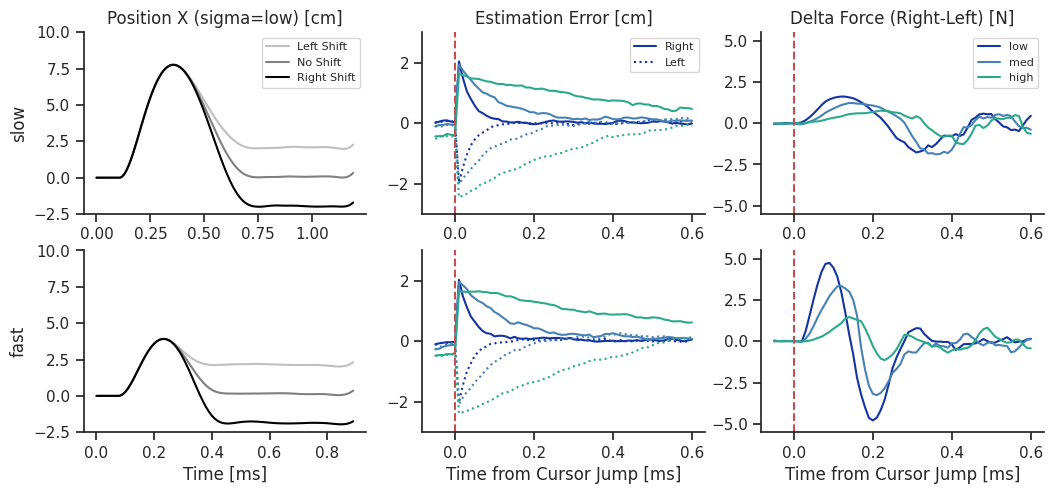

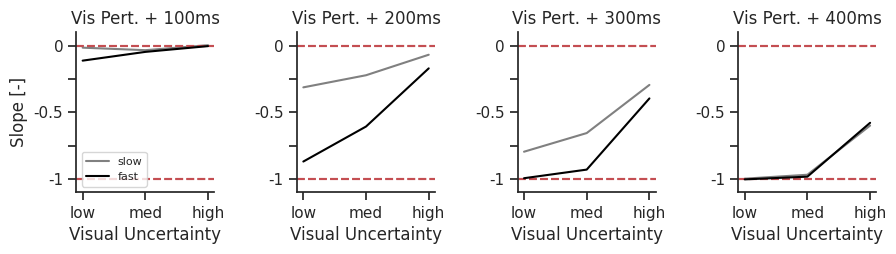

In [ ]:
# @title Run simulations & Make figures (change here: additive or multiplicative noise)
# Note: change to multnoise=True to run model with signal-dependent noise

# Run simulations --------------------------------------------------------------
with_sdn = False  # set to True for model with signal-dependent noise
change_duration = False  # set to True to display visual feedback fro differnt durations
fully_observable = False  # set to True to simulate fully observable model
move_times = [0.7,0.4]  # movement times [slow,fast]

Data, kalmanGains, controlGains, timeVisOn = runSimulations(G=0.1,m=1,tau=0.066,
                                                            delta=0.01,nState=12,
                                                            nCtrl=2,r=10**-4,
                                                            wposh=0,wposc=1000,
                                                            wvel=0,tarycoor=0.2,
                                                            nSimu=25,load=9,
                                                            stime=0.5,
                                                            mtimes=move_times,
                                                            vsigmas=[0.1,1,10],
                                                            cshifts=[-0.02,0,0.02],
                                                            multnoise=with_sdn,
                                                            changedur=change_duration,
                                                            fullobs=fully_observable)

# Figure 1: Plot x-positions, x-errors, & x-delta force ------------------------

sns.set_theme()
sns.set_style("ticks")
fig = plt.figure(figsize=(12,5))
timevec = [i/1000 for i in range(-50,610,10)]

for iTime in range(0,2):

  if move_times[iTime] == 0.7:
    timeveclong = [i/1000 for i in range(0,1200,10)]
    nStep = 120
  elif move_times[iTime] == 0.4:
    timeveclong = [i/1000 for i in range(0,900,10)]
    nStep = 90

  ax1 = plt.subplot2grid((2,3),(iTime,0),rowspan=1,colspan=1)
  ax2 = plt.subplot2grid((2,3),(iTime,1),rowspan=1,colspan=1)
  ax3 = plt.subplot2grid((2,3),(iTime,2),rowspan=1,colspan=1)
  plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.2)

  # positions:
  pos_sigma0 = np.nanmean(Data['posXall'][iTime,0,:,:,:],axis=1)

  # errors:
  err_sigma0 = np.nanmean(Data['errorX'][iTime,0,:,:,:],axis=1)
  err_sigma1 = np.nanmean(Data['errorX'][iTime,1,:,:,:],axis=1)
  err_sigma2 = np.nanmean(Data['errorX'][iTime,2,:,:,:],axis=1)

  # forces:
  # compute means to plot
  for_sigma0 = np.nanmean(Data['forceX'][iTime,0,:,:,:],axis=1)
  for_sigma1 = np.nanmean(Data['forceX'][iTime,1,:,:,:],axis=1)
  for_sigma2 = np.nanmean(Data['forceX'][iTime,2,:,:,:],axis=1)
  # subtract shift-no shift
  for_sigma0_left = for_sigma0[0,:]-for_sigma0[1,:]
  for_sigma0_right = for_sigma0[2,:]-for_sigma0[1,:]
  for_sigma1_left = for_sigma1[0,:]-for_sigma1[1,:]
  for_sigma1_right = for_sigma1[2,:]-for_sigma1[1,:]
  for_sigma2_left = for_sigma2[0,:]-for_sigma2[1,:]
  for_sigma2_right = for_sigma2[2,:]-for_sigma2[1,:]

  # make plots
  # 1: positions
  ax1.plot(timeveclong,pos_sigma0[0,:nStep],color=(0.75,0.75,0.75))
  ax1.plot(timeveclong,pos_sigma0[1,:nStep],color=(0.5,0.5,0.5))
  ax1.plot(timeveclong,pos_sigma0[2,:nStep],color=(0,0,0))

  ax1.spines.right.set_visible(False)
  ax1.spines.top.set_visible(False)
  if iTime == 0:
    if change_duration == True:
      ax1.set_ylabel("slow (duration: 100ms)")
    elif change_duration == False:
      ax1.set_ylabel("slow")
    ax1.set_title("Position X (sigma=low) [cm]")
    ax1.legend(['Left Shift','No Shift','Right Shift'],prop={'size': 8})
  elif iTime == 1:
    ax1.set_xlabel("Time [ms]")
    if change_duration == True:
      ax1.set_ylabel("slow (duration: 170ms)")
    elif change_duration == False:
      ax1.set_ylabel("fast")
  ax1.set_ylim([-2.5,10])

  # 2: estimation errors
  left, = ax2.plot(timevec,err_sigma0[0,:],':',color=(20/255,52/255,164/255),
                   label="Left")
  right, = ax2.plot(timevec,err_sigma0[2,:],color=(20/255,52/255,164/255),
                    label="Right")

  ax2.plot(timevec,err_sigma1[0,:],':',color=(70/255,130/255,180/255))
  ax2.plot(timevec,err_sigma1[2,:],color=(70/255,130/255,180/255))

  ax2.plot(timevec,err_sigma2[0,:],':',color=(42/255,170/255,138/255))
  ax2.plot(timevec,err_sigma2[2,:],color=(42/255,170/255,138/255))

  ax2.spines.right.set_visible(False)
  ax2.spines.top.set_visible(False)
  if iTime == 0:
    ax2.set_title("Estimation Error [cm]")
    ax2.legend([right, left], ['Right', 'Left'],prop={'size': 8})
    if change_duration == True:
      ax2.axvline(x=0.1,color='r',linestyle='dashed')
  elif iTime == 1:
    ax2.set_xlabel("Time from Cursor Jump [ms]")
    if change_duration == True:
      ax2.axvline(x=0.17,color='r',linestyle='dashed')
  ax2.axvline(x=0,color='r',linestyle='dashed')
  ax2.set_ylim([-3,3])

  # 3: delta forces
  ax3.plot(timevec,for_sigma0_right-for_sigma0_left,color=(20/255,52/255,164/255))
  ax3.plot(timevec,for_sigma1_right-for_sigma1_left,color=(70/255,130/255,180/255))
  ax3.plot(timevec,for_sigma2_right-for_sigma2_left,color=(42/255,170/255,138/255))

  ax3.spines.right.set_visible(False)
  ax3.spines.top.set_visible(False)
  if iTime == 0:
    ax3.set_title("Delta Force (Right-Left) [N]")
    ax3.legend(['low','med','high'],prop={'size': 8})
  elif iTime == 1:
    ax3.set_xlabel("Time from Cursor Jump [ms]")
  ax3.axvline(x=0,color='r',linestyle='dashed')
  ax3.set_ylim([-5.5,5.5])

# Figure 2: Plot slopes --------------------------------------------------------

sns.set_theme()
sns.set_style("ticks")
fig = plt.figure(figsize=(10,2))

# create subplots
ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)
ax2 = plt.subplot2grid((1,4),(0,1),rowspan=1,colspan=1)
ax3 = plt.subplot2grid((1,4),(0,2),rowspan=1,colspan=1)
ax4 = plt.subplot2grid((1,4),(0,3),rowspan=1,colspan=1)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.6,
                    hspace=0.4)

nSimu=25  # number of simulations
axes = [ax1,ax2,ax3,ax4]
idx = [15,25,35,45]  # Vis. Pert. + 100, 200, 300, 400ms
tpnts = ["100ms","200ms","300ms","400ms"]
colors = [(.5,.5,.5),(0,0,0)]

for iTime in range(0,2):

  for iPnt in range(0,4):

    betas = np.empty(shape=(3,2))

    for iVsig in range(0,3):
      pos = Data['posX'][iTime,iVsig,:,:,idx[iPnt]]

      # create arrays to compute slopes
      y = np.concatenate((pos[0,:],pos[1,:],pos[2,:]),axis=0)
      x1 = np.ones(shape=(nSimu*3,1))
      x2 = np.concatenate((np.ones(shape=(nSimu,1))*-2,\
                           np.zeros(shape=(nSimu,1)),\
                           np.ones(shape=(nSimu,1))*2))
      X = np.concatenate((x1,x2),axis=1)

      # compute slopes
      betas[iVsig,:] = np.linalg.pinv(X) @ y

    axes[iPnt].axhline(y=0,color='r',linestyle='dashed',label='_nolegend_')
    axes[iPnt].axhline(y=-1,color='r',linestyle='dashed',label='_nolegend_')
    axes[iPnt].plot(range(0,3),betas[:,1],color=colors[iTime])
    axes[iPnt].set_xticks([0,1,2],labels=['low','med','high'])
    axes[iPnt].set_yticks([-1,-0.75,-0.5,-0.25,0],
                          labels=['-1','','-0.5','','0'])
    axes[iPnt].set_ylim([-1.1,0.1])
    axes[iPnt].spines.right.set_visible(False)
    axes[iPnt].spines.top.set_visible(False)
    axes[iPnt].set_xlabel("Visual Uncertainty")
    axes[iPnt].set_title("Vis Pert. + {}".format(tpnts[iPnt]))
    if iPnt == 0:
      axes[iPnt].set_ylabel("Slope [-]")
      if change_duration == True:
        axes[iPnt].legend(['slow-100ms','slow-170ms'],loc='lower left',prop={'size': 8})
      elif change_duration == False:
        axes[iPnt].legend(['slow','fast'],loc='lower left',prop={'size': 8})


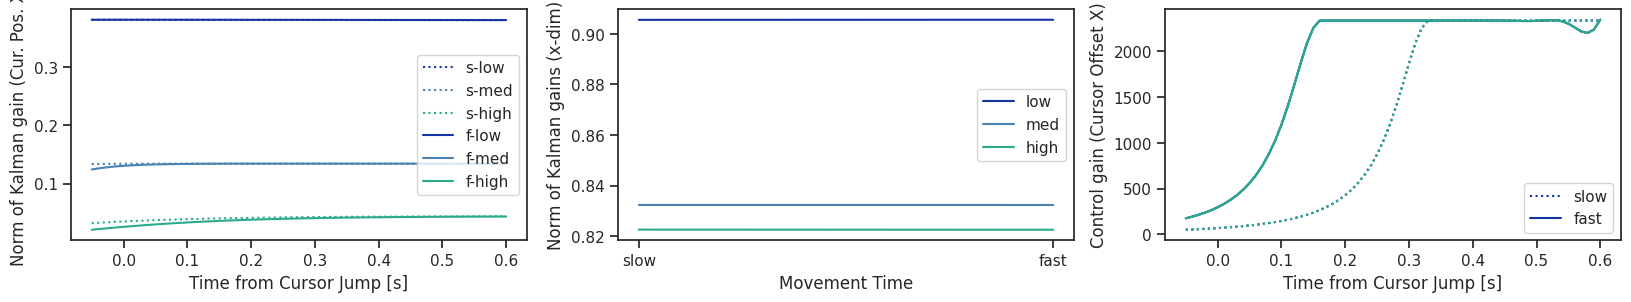

In [ ]:
# @title Plot Kalman & Control gains

# make figure
fig = plt.figure(figsize=(20,3))
labels = ['slow','fast']
linestyles = [':','-']

# plot norm of Kalman gains influencing estimation of cursor x-pos (entry 4 in state vector)
ax0 = plt.subplot2grid((1, 3), (0, 0), rowspan = 1, colspan=1)

for d in range(2):
  KwP_low = [np.linalg.norm(kalmanGains[d,0,2,i,0:6,4]) for i in range(66)]
  KwP_med = [np.linalg.norm(kalmanGains[d,1,2,i,0:6,4]) for i in range(66)]
  KwP_high = [np.linalg.norm(kalmanGains[d,2,2,i,0:6,4]) for i in range(66)]
  ax0.plot(timevec,KwP_low,linestyles[d],color=(20/255,52/255,164/255),linewidth=1.5)
  ax0.plot(timevec,KwP_med,linestyles[d],color=(70/255,130/255,180/255),linewidth=1.5)
  ax0.plot(timevec,KwP_high,linestyles[d],color=(42/255,170/255,138/255),linewidth=1.5)

ax0.set_ylabel('Norm of Kalman gain (Cur. Pos. X)')
ax0.set_xlabel('Time from Cursor Jump [s]')
ax0.legend(['s-low','s-med','s-high','f-low','f-med','f-high'],loc='center right')

# plot norm of Kalman gains corresponding to x-dimension (entries 0-5 in state vector)
ax1 = plt.subplot2grid((1, 3), (0, 1), rowspan = 1, colspan=1)

# dimensions of Kalman gain matrix: shape=(nTimes,nVsigmas,nCshifts,nMax,nAug,nAug)
KwP_low = [np.linalg.norm(kalmanGains[i,0,2,50,0:6,0:6]) for i in range(2)]
KwP_med = [np.linalg.norm(kalmanGains[i,1,2,50,0:6,0:6]) for i in range(2)]
KwP_high = [np.linalg.norm(kalmanGains[i,2,2,50,0:6,0:6]) for i in range(2)]

ax1.set_xticks([0,1],labels)
ax1.plot([0,1],KwP_low,color=(20/255,52/255,164/255))
ax1.plot([0,1],KwP_med,color=(70/255,130/255,180/255))
ax1.plot([0,1],KwP_high,color=(42/255,170/255,138/255))
ax1.set_ylabel('Norm of Kalman gains (x-dim)')
ax1.set_xlabel('Movement Time')
ax1.legend(['low','med','high'],loc='center right')

# plot control gains corresponding to cursor x offset (entry 5 in state vector)
ax2 = plt.subplot2grid((1, 3), (0, 2), rowspan = 1, colspan=1)

for d in range(2):
  ax2.plot(timevec,controlGains[d,0,2,:,0,5],linestyles[d],color=(20/255,52/255,164/255),linewidth=1.5)
  ax2.plot(timevec,controlGains[d,1,2,:,0,5],linestyles[d],color=(70/255,130/255,180/255),linewidth=1.5,label='_nolegend_')
  ax2.plot(timevec,controlGains[d,2,2,:,0,5],linestyles[d],color=(42/255,170/255,138/255),linewidth=1.5,label='_nolegend_')

ax2.set_ylabel('Control gain (Cursor Offset X)')
ax2.set_xlabel('Time from Cursor Jump [s]')
ax2.legend(labels,loc='lower right')